# Risikorechnung zu Covid-Infektionen nach 2 negativen Testergebnissen

Dieses Programm berechnet die Anzahl der falsch negativen Ergebnisse (d. h. der mit Sars-CoV-2 infizierten Personen die dennoch negativ getestet wurden) in einer Gruppe von *n* symptomfreien Personen zum Zeitpunkt *t_event*, die zu zwei festgelegten Zeitpunkten getestet werden: zum Zeitpunkt *t_PCR* mit einem PCR-Test und zum Zeitpunkt *t_event* mit einem Schnelltest. Dabei wird die Zeit zwischen Ansteckung und Testzeitpunkten beachtet, da sie aufgrund der sich verändernden Viruslast einen Einfluss auf die Test-Sentitivität und auch auf die Infektiosität der Person hat. Da es keine aufschlussreichen Daten zur Sensitivität bei symptomfrei infizierten Personen in Abhängigkeit von der Zeit seit Ansteckung gibt, nehmen wir an dass diese sich ähnlich verhält wie bei symptomatisch infizierten Personen.

Ferner nehmen wir mangels guter Daten an, dass sich der Verlauf der Sensitivität beim Schnelltest proportional zum PCR-Test verhält, man also die Schnelltest-Sensitivität in Abhängigkeit von der Zeit seit Ansteckung als Anteil an der PCR-Sensitivität berechnen kann.
Die gegebenen Daten decken einen Zeitraum von 21 Tagen zwischen Ansteckung und t_event ab, und da nach 21 Tagen die Sensitivität (und Viruslast) stark reduziert sind, werden weiter zurückliegende Ansteckungen vernachlässigt.
Die Grundwahrscheinlichkeit einer Ansteckung wird für jede Person unabhängig betrachtet.

**Datenquellen**

PCR-Sensitivität in Abh. von Tagen nach Ansteckung: https://www.acpjournals.org/doi/10.7326/m20-1495 mit Datenrepo unter https://github.com/HopkinsIDD/covidRTPCR

Schnelltest-Sensitivität (relativ zur PCR-Sensitivität): https://www.finddx.org/wp-content/uploads/2020/12/Panbio_Ag-Public-Report_v2.1.pdf

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Zentrale Berechnung der Wahrscheinlichkeit, trotz negativem Ergebnis infiziert zu sein:

In [2]:
def p_sick_negative(p_false_negatives, infection_prob, specificity):
    numerator = p_false_negatives * infection_prob
    denominator = numerator + (specificity * (1 - infection_prob))
    p_sick_neg = numerator/denominator
    return p_sick_neg

Gesamtfunktion definieren:

In [3]:
def post_test_risk(printmessage, t_PCR, t_event, average_incidence, n, time_window, scenario, 
                   PCR_specificity, PCR_FNR_days, Rapid_sensitivity, Rapid_specificity):

    daily_infectionprob = average_incidence/7/100000

    # Infektionswahrscheinlichkeit nach Tagen konditionalisieren (Ansteckungswahrscheinlichkeit für jeden Tag unter der Annahme, dass am Tag davor keine Ansteckung stattfand; bei sehr geringen Infektionswahrscheinlichkeiten unnötig):
    total_infections = round(daily_infectionprob*time_window*n)

    # Berechnung von p( infiziert | PCR-negativ ) zum Zeitpunkt t_PCR:
    p_false_negatives = PCR_FNR_days.loc[-t_PCR:time_window-1, scenario].values # FNR nur für die relevanten vorhergehenden Tage
    p_false_negatives = p_false_negatives[::-1] # Reihenfolge umkehren (da wir von t_event rückwärts rechnen)

    p_sick_neg_PCR = p_sick_negative(p_false_negatives, daily_infectionprob, PCR_specificity)

    # Der in der weiteren Rechnung verwendete Infektionswahrscheinlichkeits-Vektor setzt sich aus p_sick_neg_PCR und der
    # "rohen" Infektionswahrscheinlichkeit an den Tagen zwischen t_PCR und t_event zusammen.
    infection_prob2 = np.asarray([*p_sick_neg_PCR, *np.array(-t_PCR * [daily_infectionprob])])
    #print(infection_prob2)

    # Berechnung von p( infiziert | Schnelltest-negativ ) zum Zeitpunkt t_event:
    p_false_negatives = PCR_FNR_days.loc[-t_event:time_window-1, scenario].values # FNR nur für die relevanten vorhergehenden Tage
    p_false_negatives = 1 - Rapid_sensitivity * (1 - p_false_negatives) # Schnelltest-Sensitivität als Anteil der PCR-Sensi
    p_false_negatives = p_false_negatives[::-1] # Reihenfolge umkehren (da wir von t_event rückwärts rechnen)
    #print(p_false_negatives)

    p_sick_neg_Rapid = p_sick_negative(p_false_negatives, infection_prob2, Rapid_specificity)
    #print(p_sick_neg_Rapid)

    final_risk = sum(p_sick_neg_Rapid)
    PCR_FP = round((n)*(1.0-PCR_specificity))
    Rapid_FP = round((n)*(1.0-Rapid_specificity))
    post_PCR_risk = sum(infection_prob2)

    if printmessage:
        print("Wir erwarten, dass von " + str(n) + " Besucher*innen " + str(total_infections) + " infiziert sein werden.\nBei knapp " + str(n) + " gesunden Personen wird es im PCR-Test etwa " + 
              str(PCR_FP) + " falsch positiv Getestete geben, und im Schnelltest noch einmal ca. " + str(Rapid_FP) + "." +
              "\nDie Wahrscheinlichkeit für eine Person, im Szenario '" + scenario + "' und Inzidenz " + str(average_incidence) + " nach zwei negativen Testergebnissen dennoch infiziert zu sein, " + 
              "beträgt: " + str(final_risk) + ".\nDas bedeutet, dass in einer Gruppe mit " + str(n) + " doppelt negativ getesteten Personen insgesamt ca. " + 
             str(int(round(total_probability*n, 0))) + " Personen infiziert wären.\nOhne den Schnelltest wäre die Wahrscheinlichkeit " + str(post_PCR_risk) + " und die Endzahl infizierter Personen würde " +
             str(int(round(sum(infection_prob2)*n, 0))) + " betragen.\n")
    
    return round(post_PCR_risk*n), round(final_risk*n)

Parameter definieren, Daten einlesen & nach Tagen sortieren:

In [4]:
t_PCR = -1 # Abstand zwischen Einlass und PCR-Test
t_event = 0
average_incidence = 50 # Durchschnittliche wöchentliche Neuansteckungen pro 100.000
n = 6000
time_window = 14 # Zeitfenster der Ansteckung vor t_event, das in Betracht gezogen wird (muss < 21 sein)

#scenario = "False negative rate 95% CI Lower"
#scenario = "Estimated false negative rate"
#scenario = "False negative rate 95% CI Upper"
scenario = "Crude false negative rate"

PCR_specificity = 0.99
PCR_FNR_days = pd.read_csv("./PCR_FNR_days.csv", sep=";", decimal=",")
PCR_FNR_days = PCR_FNR_days.sort_values(["Days since exposure"]).reset_index(drop=True)
#print(PCR_FNR_days)

Rapid_sensitivity = 0.974
Rapid_specificity = 0.999

printmessage = False

Berechnung durchführen

In [5]:
results = list()

for scenario in ["False negative rate 95% CI Lower", "Estimated false negative rate", 
                 "False negative rate 95% CI Upper","Crude false negative rate"]:
    for average_incidence in [25, 50, 100, 150, 200]:
        post_PCR_numbers, final_numbers = post_test_risk(printmessage, t_PCR, t_event, average_incidence, n, time_window, 
                                                   scenario, PCR_specificity, PCR_FNR_days, Rapid_sensitivity, 
                                                   Rapid_specificity)
        results.append([scenario, str(average_incidence), post_PCR_numbers, final_numbers])

results = pd.DataFrame(results,columns=["Scenario", "Average_incidence", "Post_PCR_numbers", "Final_numbers"])
results.to_csv("Post_test_risk_table.csv", sep=";", index=False)
print(results)

                            Scenario Average_incidence  Post_PCR_numbers  \
0   False negative rate 95% CI Lower                25               1.0   
1   False negative rate 95% CI Lower                50               2.0   
2   False negative rate 95% CI Lower               100               4.0   
3   False negative rate 95% CI Lower               150               5.0   
4   False negative rate 95% CI Lower               200               7.0   
5      Estimated false negative rate                25               1.0   
6      Estimated false negative rate                50               3.0   
7      Estimated false negative rate               100               6.0   
8      Estimated false negative rate               150               8.0   
9      Estimated false negative rate               200              11.0   
10  False negative rate 95% CI Upper                25               2.0   
11  False negative rate 95% CI Upper                50               4.0   
12  False ne

<Figure size 432x288 with 0 Axes>

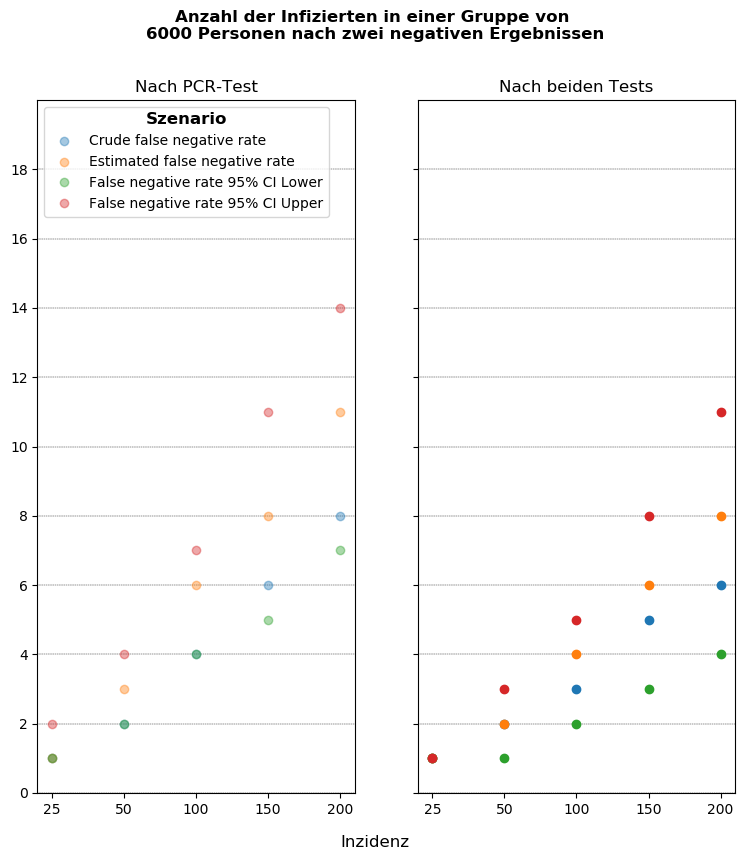

In [6]:
groups = results.groupby('Scenario')

plt.clf()
plt.style.use('default')
fig = plt.figure(figsize=(9, 9), dpi= 100, facecolor='w', edgecolor='k')
fig.suptitle("Anzahl der Infizierten in einer Gruppe von \n"+str(n)+" Personen nach zwei negativen Ergebnissen", weight="heavy")
ax = fig.add_subplot(121, polar=False)
ax.set_ylim(0,20)
plt.yticks(range(0, 20, 2))
ax.set_title("Nach PCR-Test")
for name, group in groups:
    ax.plot(group.Average_incidence, group.Post_PCR_numbers, marker='o', linestyle='', ms=6, label=name, alpha=0.4)
leg = ax.legend(prop={'size': 10}, loc='upper left')
leg.set_title('Szenario', prop={'size': 12, 'weight': 'heavy'})
ax.grid(axis='y', color='k', linestyle='--', linewidth=0.3)

ax2 = fig.add_subplot(122, polar=False)
ax2.set_ylim(0,20)
ax2.set_title("Nach beiden Tests")
for name, group in groups:
    ax2.plot(group.Average_incidence, group.Final_numbers, marker='o', linestyle='', ms=6, label=name)
ax2.grid(axis='y', color='k', linestyle='--', linewidth=0.3)
fig.text(0.5, 0.05, 'Inzidenz', ha='center', fontsize=12)
plt.yticks(range(0, 20, 2))
empty_string_labels = ['']*len(range(0, 20, 2))
ax2.set_yticklabels(empty_string_labels)
#plt.show()
plt.savefig("Abbildung.png", dpi=500)
